# Herramienta de definición de aptitud agrícola 

La planificación y gestión sostenible de los territorios rurales son fundamentales para garantizar la seguridad alimentaria, promover el desarrollo agrícola y enfrentar los desafíos del cambio climático. Es en este contexto que la evaluación de tierras toma un papel 
relevante en la planificación de su uso y propone como objetivos sistemas de producción que sean apropiados a su contexto, es decir, ambientalmente aceptables, socialmente  viables y sostenibles en el mediano y largo plazo. (Corrales et al., 2018) Para la evaluación  de tierras se han desarrollado diversas metodologías permitiendo identificar áreas con potencialidades y limitaciones específicas para actividades agropecuarias; las cuales, hacen uso de la integración de criterios biofísicos, socioeconómicos y ambientales.

El presente cuaderno busca presentar una aproximación a la aplicación de herramientas de procesamiento espacial en leguaje Python para la aplicación de una adapatación de la metodología de evaluación de aptitud agrícola de la UPRA del año 2018 en un caso de estudio que corresponde al municipio de Tunja.

**Instalación e importación de librerías necesarias para la preparación de la información**

In [3]:
!pip install rasterio folium mapclassify numpy==1.22.0 scipy==1.9.3


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [84]:
try:
    import pandas as pd
    import geopandas as gpd
    import matplotlib.pyplot as plt
    import numpy as np
    import rasterio
    import scipy
    from shapely.geometry import Polygon, MultiPolygon
    from rasterio.plot import show
    print ("✔️ Las librerías fueron cargadas correctamente")
except Exception as e:
    print ("❌ Alguna de las librerías no fueron cargadas, por favor validar la instalación de las mismas: ", e)


✔️ Las librerías fueron cargadas correctamente


**Lectura de capas vectoriales y datos tipo Ráster**

Muchas de las capas que utilizaremos para el propósito del proyecto, fueron previamente procesadas con el ánimo de trabajar únicamente xon el parea correspondiente al municipio de Tunja; para consultar el desarrollo de los procesamientos relaizados profavor acceder al siguiente repositorio de GitHub: [GeoSpatial Operations](https://github.com/jerojast/GeospatialOperations/blob/eb45734ed8100da35a5414207151a321ab23afff/Taller2_Tunja.ipynb)

In [85]:
# Rutas de los archivos locales
suelo_path = r"Estudio_Suelos_Boyaca\suelos_tunja.shp"
ecosistemas_path = r"Ecosistemas\ecosistemas_tunja.shp"
frontera_path = r"Frontera_Agricola\frontera_tunja.shp"
limite_municipal_path = r"Limite_municipal\15001_tunja.shp"
areas_protegidas_path = r"AreasProtegidas\runap_tunja.shp"
zona_rural_path = r"POT\zon_rural_pot.shp"
drenajes_path = r"POT\drenajes.shp"
perim_urbano_path = r"POT\cc_perimetrourbano.shp"
uso_path = r"POT\cobertura_uso.shp"
relleno_path = r"POT\area_proyecto.shp"
protegidasCar_path = r"POT\areas_proteg_corpob.shp"
reservaF_path = r"POT\areas_proteg_min.shp"
forestalProt_path = r"POT\forestal_proteccion.shp"
lineaFerrea_path = r"POT\linea_ferrea.shp"
zonasRestauracion_path = r"POT\restauracion.shp"
usoPotencial_path = r"POT\uso_potencial.shp"
vias_path = r"POT\vias_regionales.shp"

# Cargar los archivos SHP en GeoDataFrames
try: 
    gdf_suelo = gpd.read_file(suelo_path)
    gdf_ecosistemas = gpd.read_file(ecosistemas_path)
    gdf_frontera = gpd.read_file(frontera_path)
    gdf_limite = gpd.read_file(limite_municipal_path)
    gdf_areas_protegidas = gpd.read_file(areas_protegidas_path)
    gdf_zona_rural = gpd.read_file(zona_rural_path)
    gdf_drenajes = gpd.read_file(drenajes_path)
    gdf_perim_urbano = gpd.read_file(perim_urbano_path)
    gdf_uso = gpd.read_file(uso_path)
    gdf_relleno = gpd.read_file(relleno_path)
    gdf_protegidas_car = gpd.read_file(protegidasCar_path)
    gdf_reservafp = gpd.read_file(reservaF_path)
    gdf_forestalProt = gpd.read_file(forestalProt_path)
    gdf_lineaFerrea = gpd.read_file(lineaFerrea_path)
    gdf_ZnRestauracion = gpd.read_file(zonasRestauracion_path)
    gdf_uso_potencial = gpd.read_file(usoPotencial_path)
    gdf_vias = gpd.read_file(vias_path)
   
    print("🗺️ Capas vectoriales cargadas correctamente.")

except Exception as e:
    print ("❌ Alguna de las capas no fueron cargadas, por favor validar la ruta ingresada: ", e)

🗺️ Capas vectoriales cargadas correctamente.


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 1590, 'height': 1524, 'count': 1, 'crs': CRS.from_wkt('PROJCS["MAGNA_SIRGAS_Origen_Nacional",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","9377"]]'), 'transform': Affine(10.0, 0.0, 4950464.5,
       0.0, -10.0, 2175052.461), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}


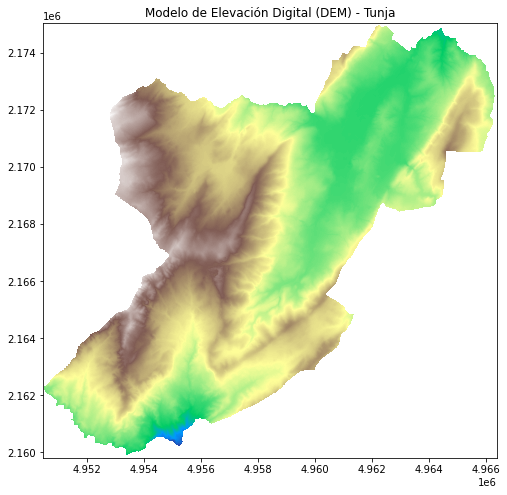

In [86]:
# Ruta del DEM
dem_path = r"DEM_Tunja\DEM.tif"

# Cargar del raster DEM
try:
    raster_dem = rasterio.open(dem_path)
    # Mostrar información del DEM
    print(raster_dem.profile)
    # Visualizar DEM
    plt.figure(figsize=(12, 8))
    plt.title("Modelo de Elevación Digital (DEM) - Tunja")
    show(raster_dem, cmap='terrain')
    plt.show()
except Exception as e:
    print ("❌ Alguna de las capas no fueron cargadas, por favor validar la ruta ingresada: ", e)


**Validación sistemas de referencia de capas vector**

En todo proyecto de procesamiento geoespacial es fundamental evaluar la unicidad de los sistemas de proyección, ello debido a que diferencias entre estos puede generar traslapes erróneos en las salidas gráficas, los procesamientos o incluso generar errores topológicos.

In [87]:
# Validar proyecciones
crs_suelo = print("Sistema de coordenadas Suelo:", gdf_suelo.crs)
crs_ecos = print("Sistema de coordenadas Ecosistemas:", gdf_ecosistemas.crs)
crs_frontera = print("Sistema de coordenadas Frontera:", gdf_frontera.crs)
crs_límite = print("Sistema de coordenadas Limite Municipal:", gdf_limite.crs)
crs_runap = print("Sistema de coordenadas Áreas Protegidas:", gdf_areas_protegidas.crs)
crs_rural = print("Sistema de coordenadas Zonficiación Rural:", gdf_zona_rural.crs)
crs_drenajes = print("Sistema de coordenadas Drenajes:", gdf_drenajes.crs)
crs_perim_urbano = print("Sistema de coordenadas Perímetro Urbano:", gdf_perim_urbano.crs)
crs_uso = print("Sistema de coordenadas Uso del Suelo:", gdf_uso.crs)
crs_relleno = print("Sistema de coordenadas relleno:", gdf_relleno.crs)
crs_protegidas_car = print("Sistema de coordenadas áreas protegidas CAR: ", gdf_areas_protegidas.crs)
crs_reservafp = print("Sistema de coordenadas Reserva FP:", gdf_reservafp.crs)
crs_forestalProt = print("Sistema de coordenadas Forestal Protegida:", gdf_forestalProt.crs)
crs_lineaFerrea = print("Sistema de coordenadas Línea Ferrea:", gdf_lineaFerrea.crs)
crs_ZnRestauracion = print("Sistema de coordenadas Zonas de Restauración:", gdf_ZnRestauracion.crs)
crs_uso_potencial = print("Sistema de coordenadas Uso Potencial:", gdf_uso_potencial.crs)
crs_vias = print("Sistema de coordenadas Vías:", gdf_vias.crs)

Sistema de coordenadas Suelo: EPSG:4326
Sistema de coordenadas Ecosistemas: EPSG:4326
Sistema de coordenadas Frontera: EPSG:4326
Sistema de coordenadas Limite Municipal: PROJCS["CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Sistema de coordenadas Áreas Protegidas: EPSG:4326
Sistema de coordenadas Zonficiación Rural: EPSG:4326
Sistema de coordenadas Drenajes: EPSG:4326
Sistema de coordenadas Perímetro Urbano: EPSG:4326
Sistema de coordenadas Uso del Suelo: EPSG:4326
Sistema de coordenadas relleno: EPSG:4326
Sistema de co

**Ajuste de las proyecciones de las capas a EPSG:9377**

In [ ]:
# Convertir todo a Origen Único Nacional EPSG:9377

proyecciones = [crs_suelo, crs_ecos, crs_frontera, crs_límite, crs_runap, crs_rural, crs_drenajes]

if any(proy != "EPSG:9377" for proy in proyecciones):
    gdf_suelo = gdf_suelo.to_crs(epsg=9377)
    gdf_ecosistemas = gdf_ecosistemas.to_crs(epsg=9377)
    gdf_frontera = gdf_frontera.to_crs(epsg=9377)
    gdf_limite = gdf_limite.to_crs(epsg=9377)
    gdf_areas_protegidas = gdf_areas_protegidas.to_crs(epsg=9377)
    gdf_zona_rural = gdf_zona_rural.to_crs(epsg=9377)
    gdf_drenajes = gdf_drenajes.to_crs(epsg=9377)
    gdf_perim_urbano = gdf_perim_urbano.to_crs(epsg=9377)
    gdf_uso = gdf_uso.to_crs(epsg=9377)
    gdf_relleno = gdf_relleno.to_crs(epsg=9377)
    gdf_protegidas_car = gdf_protegidas_car.to_crs(epsg=9377)
    gdf_reservafp = gdf_reservafp.to_crs(epsg=9377)
    gdf_forestalProt = gdf_forestalProt.to_crs(epsg=9377)
    gdf_lineaFerrea = gdf_lineaFerrea.to_crs(epsg=9377)
    gdf_ZnRestauracion = gdf_ZnRestauracion.to_crs(epsg=9377)
    gdf_uso_potencial = gdf_uso_potencial.to_crs(epsg=9377)
    gdf_vias = gdf_vias.to_crs(epsg=9377)
    print("Las capas fueron reproyectadas a EPSG:9377")
else:
    print("Las capas ya están en la proyección EPSG:9377")
    


Las capas fueron reproyectadas a EPSG:9377


Cómo deseamos evaluar la aptitud agrícola en función de las limitantes y restricciones ambientales, es decir, definir qué áreas son útiles para proyectos productivos en el nivel rural del municipio de Tunja. Para ello, iniciaremos con definiendo los límites del área a evaluar.

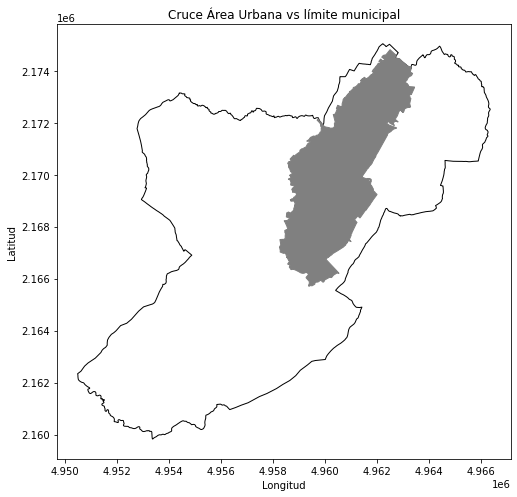

In [89]:
# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 8))

# Plot límite municipal
gdf_limite.plot(ax=ax, color='none', edgecolor='black', label='Límite Municipio de Tunja')

# Plot zona urbana
gdf_perim_urbano.plot(ax=ax, color='gray', edgecolor='gray', label='Área Urbana definida en POT de Tunja')

# Añadir leyenda y otros detalles al gráfico
ax.set_title('Cruce Área Urbana vs límite municipal')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico
plt.show()


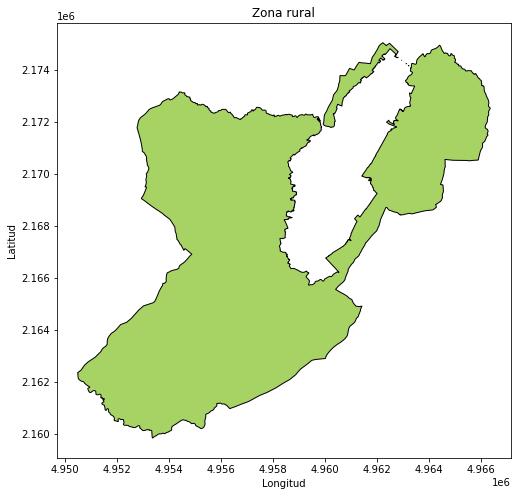

In [90]:
# Extraemos la sección que no está definida como zona urbana
gdf_zona_rural = gpd.overlay(gdf_limite, gdf_perim_urbano, how="difference")

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 8))

# Plot límite municipal
gdf_zona_rural.plot(ax=ax, color='#a6d363', edgecolor='black', label='Zona rural')

# Añadir leyenda y otros detalles al gráfico
ax.set_title('Zona rural')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico
plt.show()


Ahora validaremos el cruce con las capas que representan zonas de restricción para la producción agrícola. Para ello inicialmente evaluaremos las zonas que deben generarse áreas pues su geometría es de tipo lineal. 

In [93]:
#Buffers de capas vectoriales lineales
gdf_vias['buffer_13m'] = gdf_vias.geometry.buffer(13) #Ancho promedio de vía
gdf_drenajes['buffer_30m'] = gdf_drenajes.geometry.buffer(30) #Ronda Hídrica Dec 2811 de 1974
gdf_lineaFerrea['buffer_20m'] = gdf_lineaFerrea.geometry.buffer(20) #Zonas de línea férrea
gdf_relleno['buffer_500m'] = gdf_relleno.geometry.buffer(500) #Zonas alejadas del relleno sanitario

#Seteamos las columnas buffer como las geometrías a usar
gdf_relleno.set_geometry('buffer_500m')
gdf_vias.set_geometry('buffer_13m') 
gdf_drenajes.set_geometry('buffer_30m') 
gdf_lineaFerrea.set_geometry('buffer_20m')

#Clip de capas
gdf_vias = gpd.clip(gdf_vias, gdf_zona_rural)
gdf_drenajes = gpd.clip(gdf_drenajes, gdf_zona_rural)
gdf_lineaFerrea = gpd.clip(gdf_lineaFerrea, gdf_zona_rural)
gdf_relleno = gpd.clip(gdf_relleno, gdf_zona_rural)

In [100]:
gdf_relleno['geometry'] = gdf_relleno['buffer_500m']
gdf_vias['geometry'] = gdf_vias['buffer_13m']
gdf_drenajes['geometry'] = gdf_drenajes['buffer_30m']
gdf_lineaFerrea['geometry'] = gdf_lineaFerrea['buffer_20m']

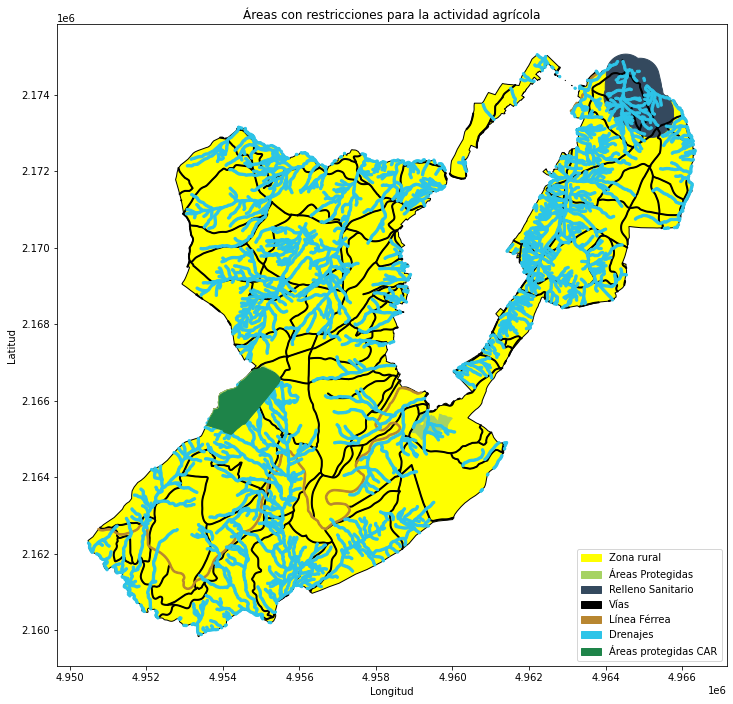

In [ ]:
import matplotlib.patches as mpatches # Para crear elementos de leyenda personalizados

# Crear figura y eje
fig, ax = plt.subplots(figsize=(12, 12))

# Plot límite municipal
gdf_zona_rural.plot(ax=ax, color='yellow', edgecolor='black', label='Zona rural')
# Plot runap
gdf_areas_protegidas.plot(ax=ax, color='#a6d363', edgecolor='#a6d363', label='Áreas Protegidas')
# Plot Relleno
gdf_relleno.plot(ax=ax, color='#34495e', edgecolor='#34495e', label='Relleno Sanitario')
# Plot vías
gdf_vias.plot(ax=ax, color='black', edgecolor='black', label='vías')
# Plot línea férrea
gdf_lineaFerrea.plot(ax=ax, color='#b88630', edgecolor='#b88630', label='Línea Férrea')
# Plot Drenajes
gdf_drenajes.plot(ax=ax, color='#2dc4e8', edgecolor='#2dc4e8', label='Drenajes')
#Plot Áreas Protegidas Corpoboyacá
gdf_protegidas_car.plot(ax=ax, color='#1e8449', edgecolor='#1e8449', label='Áreas protegidas CAR')


# Crear objetos temporales para la leyenda
proxy_zona_rural     = mpatches.Patch(color='yellow', label='Zona rural')
proxy_areas_protegidas = mpatches.Patch(color='#a6d363', label='Áreas Protegidas')
proxy_relleno         = mpatches.Patch(color='#34495e', label='Relleno Sanitario')
proxy_vias            = mpatches.Patch(color='black', label='Vías')
proxy_lineaFerrea     = mpatches.Patch(color='#b88630', label='Línea Férrea')
proxy_drenajes        = mpatches.Patch(color='#2dc4e8', label='Drenajes')
proxy_protegidas_car  = mpatches.Patch(color='#1e8449', label='Áreas protegidas CAR')

# Crear la lista de objetos y agregar la leyenda
legend_handles = [
    proxy_zona_rural,
    proxy_areas_protegidas,
    proxy_relleno,
    proxy_vias,
    proxy_lineaFerrea,
    proxy_drenajes,
    proxy_protegidas_car
]

# Añadir leyenda
ax.legend(handles=legend_handles, loc='lower right')
ax.set_title('Áreas con restricciones para la actividad agrícola')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico
plt.show()

Retiraremos las áreas con restricciones para la actividad agrícola del polígono principal de área útil:

In [104]:
#Creamos el geodataframe restricciones con base en las capas de restricción
gdf_Restricciones = pd.concat([gdf_areas_protegidas, 
                               gdf_relleno,
                               gdf_vias,
                               gdf_lineaFerrea,
                               gdf_drenajes,
                               gdf_protegidas_car], ignore_index=True)
gdf_Restricciones = gpd.GeoDataFrame(gdf_Restricciones, crs=gdf_zona_rural.crs)

In [111]:
#Agrupamos las geometrías de las restricciones en un solo registro
gdf_Restricciones = gdf_Restricciones.dissolve() #  Da facilidad de trabajar con un solo registro a la hora de hacer el clip

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


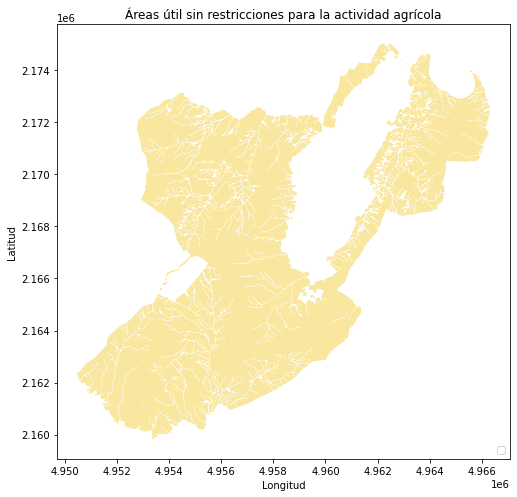

In [ ]:
gdf_znUtil_restricciones = gpd.overlay(gdf_zona_rural, gdf_Restricciones, how="difference")

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 8))

# Plot límite municipal
gdf_znUtil_restricciones.plot(ax=ax, color='#f9e79f', edgecolor='#f9e79f', label='Zona rural')

# Añadir leyenda manualmente con las entradas definidas
ax.legend(loc='lower right')
ax.set_title('Áreas útil sin restricciones normativas para la actividad agrícola')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico
plt.show()

Una de las restricciones adicionales, la vemos en el Decreto 3600 de 2007 en el numeral 2 del artículo 21 estableció como una de las condiciones para el otorgamiento de licencias de parcelación y construcción en suelo rural y rural suburbano la conservación y mantenimiento de las masas arbóreas, independiente que sean naturales o plantadas, y forestales en suelos con pendientes superiores a los 45 grados; en este sentido, es de relevancia contemplar aquellas áreas en las que se cumple este criterio y definirla a su vez como área de restricción.

In [116]:
raster_dem.res

(10.0, 10.0)

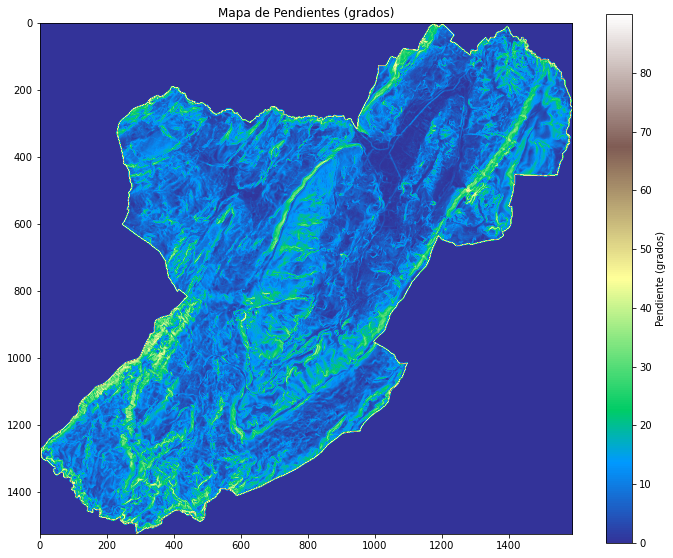

In [149]:
def calcular_pendiente(dem, pixel_size):
    """
    Calcula la pendiente en grados a partir de un array de elevaciones (DEM)
    usando el método del gradiente de NumPy.

    Parámetros:
      - dem: Array 2D con los valores de elevación.
      - pixel_size: Tamaño del píxel (asumido cuadrado) en las unidades del DEM.
    
    Retorna:
      - slope_degrees: Array 2D con la pendiente en grados.
    """
    # Calcular la derivada en x e y
    dz_dy, dz_dx = np.gradient(dem, pixel_size, pixel_size)
    # Calcular la pendiente en radianes
    slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
    # Convertir a grados
    slope_degrees = np.degrees(slope_rad)
    return slope_degrees


# Leer el DEM y obtener la resolución de píxeles
pendiente = raster_dem.read(1)  # Leer la primera banda
profile = raster_dem.profile
# Asumimos que los píxeles son cuadrados y usamos la resolución en x
pixel_size = raster_dem.res

# Calcular la pendiente en grados
slope_degrees = calcular_pendiente(pendiente, 10)

# Visualizar la pendiente en grados y la clasificación
plt.figure(figsize=(10, 8))

plt.imshow(slope_degrees, cmap='terrain')
plt.colorbar(label='Pendiente (grados)')
plt.title('Mapa de Pendientes (grados)')
plt.tight_layout()
plt.show()


# Guardar la pendiente en un archivo raster

# Actualiza el perfil para el nuevo raster
profile.update({
    'driver': 'GTiff',         # Formato de salida
    'height': slope_degrees.shape[0],     # Número de filas
    'width': slope_degrees.shape[1],      # Número de columnas
    'count': 1,                  # Número de bandas (1 para un raster de una sola banda)
    'dtype': 'int16'             # Tipo de dato (ajústalo según corresponda a tus datos)
})

# Ruta de salida del raster
output_path = "Pendientes.tif"

# Escribe el raster en disco
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(slope_degrees, 1)  # Escribe en la banda 1




In [155]:
from rasterio.features import shapes

# Crear una máscara del array para extraer solo la categoría 4 
mask_45 = slope_degrees >= 45

# Extraemos las geometrías con rasterio.features.shapes
# La función devuelve un iterador de (geometría, valor)
results = (
    {'properties': {'value': v}, 'geometry': s}
    for s, v in shapes(slope_degrees, mask=mask_45, transform=profile['transform'])
    if v >= 45  # filtra solo las geometrías de la categoría 4
)

# Convertimos el iterador a una lista (cada elemento es un diccionario GeoJSON)
geoms = list(results)

# Creamos un GeoDataFrame a partir de estas características
gdf_pendientes = gpd.GeoDataFrame.from_features(geoms, crs=profile['crs'])

# Opcional: Guardar la capa vectorial en un archivo shapefile
#gdf_category4.to_file("categoria4_vector.shp")

print("Se extrajeron", len(gdf_pendientes), "polígonos para pendientes iguales o mayores a 45°.")


Se extrajeron 5808 polígonos para pendientes iguales o mayores a 45°.


c:\Users\Esteban Rojas\anaconda3\lib\site-packages\pyogrio\raw.py:196: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


Text(88.64365488836313, 0.5, 'Latitud')

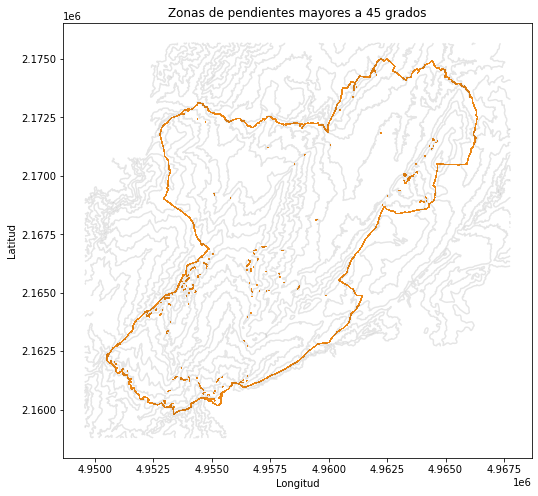

In [156]:
# Visualizar las zonas de pendientes mayores a 45 grados

curvas_path = r"POT\curva_nivel.shp"
gdf_curvas = gpd.read_file(curvas_path)
gdf_curvas = gdf_curvas.to_crs(epsg=9377)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 8))

# Plot áreas con pendientes mayores a 45°
gdf_pendientes.plot(ax=ax, color='#ec8613', edgecolor='#ec8613', label='Zonas de pendientes mayores a 45 grados')

# Plot curvas de nivel
gdf_curvas.plot(ax=ax, color='black', alpha=0.1)

# Añadir leyenda manualmente con las entradas definidas
ax.set_title('Zonas de pendientes mayores a 45 grados')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

Teniendo los pológonos de las áreas con pendientes superiores a 45°, procederemos a definir ahora sí el área útil sin restricciones técnicas ni normativas.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


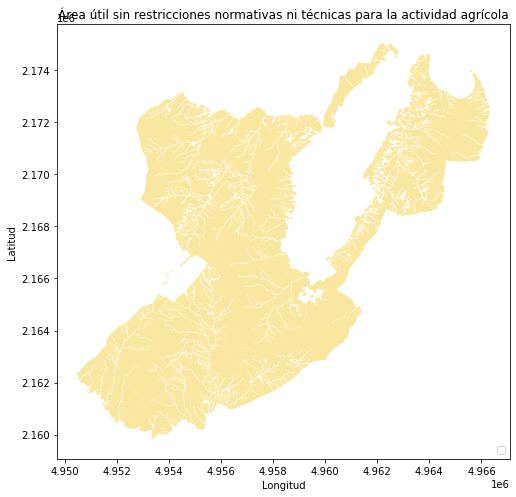

In [ ]:
gdf_znUtil_restricciones = gpd.overlay(gdf_znUtil_restricciones, gdf_pendientes, how="difference")

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 8))

# Plot límite municipal
gdf_znUtil_restricciones.plot(ax=ax, color='#f9e79f', edgecolor='#f9e79f', label='Zona rural')

# Añadir leyenda manualmente con las entradas definidas
ax.legend(loc='lower right')
ax.set_title('Área útil sin restricciones normativas ni técnicas para la actividad agrícola')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el gráfico
plt.show()

In [160]:
# Guardar la capa vectorial en un archivo shapefile
gdf_znUtil_restricciones.to_file("Zona_Util/Zona_util_sin_restricciones.shp")

c:\Users\Esteban Rojas\anaconda3\lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Value 119518460.983999997 of field SHAPE_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(


**Validación de condicionantes**

Las limitantes se refieren a las capas que por su condición no restringen la actividad agropecuaria, pero sí la condicionan, por lo que la actividad agrícola requiere de ciertas consideraciones para su desarrollo, como permisos ambientales, el establecimiento de ciertos proyectos productivos, regulaciones, entre otros. Dentro de estos encontramos las reservas forestales productoras, las zonas definidas como de restauración ecológica según el POT, el uso potencial definido en el POT, entre otros.

In [161]:
# Procesaremos las capas necesarias para poder definir las limitantes

# Dissolve de polígonos para mejorar el tratamiento de los procesos geoespaciales entre capas



,OBJECTID,MpCodigo,MpNombre,MpArea,MpNorma,MpCategor,MpAltitud,Restriccio,Depto,Ley617,SHAPE_Leng,SHAPE_Area,geometry
0,552,15001,Tunja,11951.846098,None,1,2778,“No es apropiada su aplicación para la ubicaci...,Boyacá,1,63344.60903,1.195185e+08,"MULTIPOLYGON Z (((4953394.5 2159862.461 0, 495..."


**Cálculo de estadísticas descriptivas de las capas vectoriales**

In [28]:
# Convertir categorías de 'nombre' en números en la capa Zona Rural, ya que es un campo descriptivo
if "nombre" in gdf_zona_rural.columns:
    gdf_zona_rural["nombre_cod"] = gdf_zona_rural["nombre"].astype("category").cat.codes
    print("✔️ Se asignaron códigos numéricos a 'nombre' en Zona Rural.")

✔️ Se asignaron códigos numéricos a 'nombre' en Zona Rural.


In [30]:
# Definir nuevamente los GeoDataFrames con las variables corregidas
gdf_layers = {
    "Suelos": gdf_suelo,
    "Frontera Agrícola": gdf_frontera,
    "Zona Rural": gdf_zona_rural,
    "Drenajes": gdf_drenajes,  # Asegurar que es la capa correcta
    "Áreas Protegidas": gdf_areas_protegidas,
    "Ecosistemas": gdf_ecosistemas
}

# Actualizar las columnas seleccionadas
selected_columns = {
    "Suelos": ["ÁREA_ha"],
    "Frontera Agrícola": ["area_ha"],
    "Zona Rural": ["nombre_cod"],  # Usamos el nuevo código numérico
    "Drenajes": ["long_ml"],  # Se corrigió el nombre del campo
    "Áreas Protegidas": ["area_ha_to"],
    "Ecosistemas": ["RELIEVE", "SUELOS", "COBERTURA"]
}

# Calcular estadísticas nuevamente
for name, cols in selected_columns.items():
    gdf = gdf_layers.get(name, None)  # Obtener la capa correspondiente

    if gdf is not None and isinstance(gdf, gpd.GeoDataFrame):  # Verificar si es un GeoDataFrame válido
        available_cols = [col for col in cols if col in gdf.columns]  # Filtrar columnas existentes
        if available_cols:
            print(f"\n📊 🤔Estadísticas de {name}:\n", gdf[available_cols].describe())
        else:
            print(f"\n⚠️ {name} no tiene columnas numéricas para calcular estadísticas.")
    else:
        print(f"\n⚠️ No se encontró un GeoDataFrame válido para '{name}'.")


📊 🤔Estadísticas de Suelos:
            ÁREA_ha
count    21.000000
mean   1652.742518
std    2036.039451
min      44.951934
25%     349.302355
50%    1578.848157
75%    1869.273224
max    9351.252678

📊 🤔Estadísticas de Frontera Agrícola:
             area_ha
count     32.000000
mean    2184.517532
std     3109.530864
min        0.000128
25%        0.036491
50%        6.535639
75%     4622.383457
max    11381.672150

📊 🤔Estadísticas de Zona Rural:
        nombre_cod
count   97.000000
mean     1.845361
std      1.438606
min     -1.000000
25%      0.000000
50%      3.000000
75%      3.000000
max      5.000000

📊 🤔Estadísticas de Drenajes:
             long_ml
count   1153.000000
mean     522.276145
std     1548.048978
min        9.470990
25%      159.136829
50%      258.470148
75%      477.498617
max    37244.999247

📊 🤔Estadísticas de Áreas Protegidas:
        area_ha_to
count    2.000000
mean    98.746650
std     84.249440
min     39.173300
25%     68.959975
50%     98.746650
75%    12

**Normalización de variables numéricas**

In [32]:
# Función para normalizar valores entre 0 y 1
def normalizar(columna):
    # Convert the column to numeric, handling errors by coercing to NaN
    columna = pd.to_numeric(columna, errors='coerce')
    return (columna - columna.min()) / (columna.max() - columna.min())

# Aplicar normalización a las variables relevantes
gdf_suelo["norm_area_ha"] = normalizar(gdf_suelo["ÁREA_ha"])
gdf_frontera["norm_area_ha"] = normalizar(gdf_frontera["area_ha"])
gdf_zona_rural["norm_nombre_cod"] = normalizar(gdf_zona_rural["nombre_cod"])
gdf_drenajes["norm_long_ml"] = normalizar(gdf_drenajes["long_ml"])
gdf_areas_protegidas["norm_area_ha_to"] = normalizar(gdf_areas_protegidas["area_ha_to"])
gdf_ecosistemas["norm_relieve"] = normalizar(gdf_ecosistemas["RELIEVE"])  # Asegurar que RELIEVE sea numérico

print("✔️ Normalización de variables completada.")

✔️ Normalización de variables completada.


**Definición de pesos para él cálculo del índice de aptitud**

In [34]:
# Definir pesos para cada variable en el índice de aptitud
pesos = {
    "norm_area_ha": 0.2,
    "norm_area_ha_frontera": 0.2,
    "norm_nombre_cod": 0.1,
    "norm_long_ml": 0.15,
    "norm_area_ha_to": 0.15,
    "norm_relieve": 0.2
}

**Unión espacial**

In [36]:
# Asegurar que todas las capas tengan el mismo CRS antes de unirlas
gdf_suelo = gdf_suelo.to_crs(epsg=4326)
gdf_frontera = gdf_frontera.to_crs(epsg=4326)
gdf_zona_rural = gdf_zona_rural.to_crs(epsg=4326)
gdf_drenajes = gdf_drenajes.to_crs(epsg=4326)
gdf_areas_protegidas = gdf_areas_protegidas.to_crs(epsg=4326)
gdf_ecosistemas = gdf_ecosistemas.to_crs(epsg=4326)

# Hacer una unión espacial para combinar datos de las capas en gdf_union
gdf_union = gdf_suelo.copy()

gdf_union = gdf_union.sjoin(gdf_frontera, how="left", predicate="intersects")

# Renombrar o eliminar la columna 'index_right' de gdf_union antes de la siguiente unión
#gdf_union = gdf_union.rename(columns={"index_right": "index_right_frontera"})  # Renombrar para evitar conflictos

# Eliminamos la columna index_right para evitar conflictos en las siguientes uniones
gdf_union = gdf_union.drop(columns=['index_right'])

# Renombrar columna de gdf_zona_rural antes de la unión (si es necesario)
#gdf_zona_rural = gdf_zona_rural.rename(columns={"index_right": "index_right_zr"})
gdf_union = gdf_union.sjoin(gdf_zona_rural, how="left", predicate="intersects")

# Eliminamos la columna index_right para evitar conflictos en las siguientes uniones
gdf_union = gdf_union.drop(columns=['index_right'])

gdf_union = gdf_union.sjoin(gdf_drenajes, how="left", predicate="intersects")

# Eliminamos la columna index_right para evitar conflictos en las siguientes uniones
gdf_union = gdf_union.drop(columns=['index_right'])

gdf_union = gdf_union.sjoin(gdf_areas_protegidas, how="left", predicate="intersects")

# Eliminamos la columna index_right para evitar conflictos en las siguientes uniones
gdf_union = gdf_union.drop(columns=['index_right'])

gdf_union = gdf_union.sjoin(gdf_ecosistemas, how="left", predicate="intersects")

# Verificar si la unión espacial se hizo correctamente
print("✔️ Unión espacial realizada correctamente.")
print("Columnas después de la unión:", gdf_union.columns)

✔️ Unión espacial realizada correctamente.
Columnas después de la unión: Index(['UCS', 'UCS_F', 'PAISAJE_left', 'CLIMA_left', 'TIPO_RELIE', 'LITOLOGÍA',
       'CARACTERÍ', 'COMPONENTE', 'PERFIL', 'PORCENTAJE',
       ...
       'REPTILES', 'No_Anfibio', 'No_Aves', 'No_Magnoli', 'No_Mamifer',
       'No_Reptile', 'SHAPE_Leng_right', 'SHAPE_Area_right', 'RULEID',
       'norm_relieve'],
      dtype='object', length=123)


**Revisión de índices**

In [38]:
print("🔍 Índice de gdf_suelo:", gdf_suelo.index)
print("🔍 Índice de gdf_union:", gdf_union.index)

print("\n🔍 Primeras filas de gdf_suelo:")
print(gdf_suelo.head())

print("\n🔍 Primeras filas de gdf_union:")
print(gdf_union.head())

🔍 Índice de gdf_suelo: RangeIndex(start=0, stop=21, step=1)
🔍 Índice de gdf_union: Index([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       ...
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
      dtype='int64', length=2286176)

🔍 Primeras filas de gdf_suelo:
   UCS  UCS_F                   PAISAJE                    CLIMA  \
0  AHV  AHVe1  Altiplanicie estructural  Muy frío y frío, húmedo   
1  AMH   AMHa  Altiplanicie estructural               Frío, seco   
2   ME     ME     Misceláneo erosionado    Misceláneo erosionado   
3  AMV  AMVd1  Altiplanicie estructural               Frío, seco   
4   ZU     ZU               Zona urbana              Zona urbana   

              TIPO_RELIE                                          LITOLOGÍA  \
0         Lomas y glacís  Depósitos superﬁciales piroclásticos de ceniza...   
1             Vallecitos            Depósitos superﬁciales clásticos mixtos   
2  Misceláneo erosionado                              Misceláneo erosionado   
3         Lomas y

**Verificar y corregir geometrías inválidas**

In [40]:
from shapely.geometry import Polygon, MultiPolygon

# Función para corregir geometrías inválidas rápidamente
def corregir_geometria(geom):
    if geom.is_valid:
        return geom
    else:
        try:
            return geom.buffer(0)  # Última opción si sigue inválido
        except:
            return None  # Si no se puede corregir, lo elimina

# Aplicar la corrección solo a las geometrías inválidas
gdf_suelo["geometry"] = gdf_suelo["geometry"].apply(corregir_geometria)
gdf_union["geometry"] = gdf_union["geometry"].apply(corregir_geometria)

# Verificar si aún hay geometrías inválidas
print("✔️ Geometrías corregidas. Inválidas restantes:", gdf_suelo.is_valid.sum())

✔️ Geometrías corregidas. Inválidas restantes: 21


**Eliminar geometrías inválidas**

In [44]:
# Número total de geometrías en gdf_suelo antes de filtrar
print("🔍 Número total de geometrías en gdf_suelo:", len(gdf_suelo))

# Verificar cuántas son válidas y cuántas inválidas
print("✔️ Geometrías válidas en gdf_suelo:", gdf_suelo.is_valid.sum())
print("❌ Geometrías inválidas en gdf_suelo:", (~gdf_suelo.is_valid).sum())

# Verificar geometrías vacías y nulas
print("🕳️ Geometrías vacías en gdf_suelo:", gdf_suelo.is_empty.sum())
print("❌ Geometrías nulas en gdf_suelo:", gdf_suelo.geometry.isna().sum())

# Revisar el área de las geometrías
gdf_suelo["area"] = gdf_suelo.geometry.area
print("📏 Estadísticas del área de las geometrías:\n", gdf_suelo["area"].describe())

# Confirmar sistema de coordenadas
print("🌐 CRS de gdf_suelo:", gdf_suelo.crs)
print("🌐 CRS de gdf_union:", gdf_union.crs)

# Seleccionar solo las geometrías válidas
gdf_suelo = gdf_suelo[gdf_suelo.is_valid == True]
gdf_union = gdf_union[gdf_union.is_valid == True]

print("✔️ Geometrías inválidas eliminadas. Número de registros restantes:", len(gdf_suelo))

🔍 Número total de geometrías en gdf_suelo: 21
✔️ Geometrías válidas en gdf_suelo: 21
❌ Geometrías inválidas en gdf_suelo: 0
🕳️ Geometrías vacías en gdf_suelo: 0
❌ Geometrías nulas en gdf_suelo: 0
📏 Estadísticas del área de las geometrías:
 count    21.000000
mean      0.000465
std       0.000451
min       0.000002
25%       0.000056
50%       0.000307
75%       0.000685
max       0.001463
Name: area, dtype: float64
🌐 CRS de gdf_suelo: EPSG:4326
🌐 CRS de gdf_union: EPSG:4326


C:\Users\Paula Cardona\AppData\Local\Temp\ipykernel_13860\3227342954.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_suelo["area"] = gdf_suelo.geometry.area


✔️ Geometrías inválidas eliminadas. Número de registros restantes: 21


In [45]:
# Hacer join espacial para asegurar que norm_area_ha se transfiera

gdf_union = gdf_union.sjoin(gdf_suelo[["geometry", "norm_area_ha"]], how="left", predicate="intersects")
print("✔️ Se agregó norm_area_ha correctamente con sjoin.")

ValueError: 'index_right' cannot be a column name in the frames being joined